In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import random

import os

# Simulation Project V4 (FA23)

The purpose of this notebook is to further modularize simulation model v1 and incorporate our own twists to examine the behavior of gender-based bias in the corporate workplace.

In [98]:
# Global Variables / References:

# number-char correspondences for pretty printing
work_levels = {
    1 : "J",
    2 : "M",
    3 : "S",
    4 : "E"
}

worker_genders = {
    0 : "M",
    1 : "F"
}

# Appropriate staff sizes for each level:
level_sizes = {
    1 : 1000,
    2 : 300,
    3 : 75,
    4 : 25
}

# The impact that seniority has on staying time - older people retire later?
# Set negative for opposite effect.
level_ext_stay_times = {
    1 : 1,
    2 : 4,
    3 : 6,
    4 : 10
}

# The impact that gender has on staying time -- women pushed out quicker?
gender_stay_times = {
    0 : 5,
    1 : 3
}

# A database to store workers, organized by level:
# Implemented as simple lists, ordered from most to least senior by employee index.
worker_db = {
    1 : [],
    2 : [],
    3 : [],
    4 : []
}

In [99]:
# Worker Class:
class worker(object):
    
    def __init__(self, level, gender, idx, start_time):
        self.level = level
        self.gender = gender
        self.idx = idx
        self.age = 12*level + random.randint(10,30)
        self.start_time = start_time
        
    def __str__(self):
        return "[level: %s, gender: %s, id: %i, end_time: %f]" \
            % (self.level, self.gender, self.idx, self.end_time)
        
    def get_index(self):
        return self.idx
    
    def get_level(self):
        return self.level
    
    def get_productivity(self):
        return self.productivity
    
    def set_productivity(self):
        if self.gender == 0:
            self.productivity = max(np.random.normal(4, 2), 1)
        else:
            self.productivity = max(np.random.normal(5, 2), 1)
    
    def get_time_on_level(self):
        return time.time() - self.start_time
    
    def set_end_time(self):
        
#       Setting end time for male employees
        if self.gender == 0:
            self.end_time = self.start_time \
                + np.random.exponential( \
                gender_stay_times[self.gender] + level_ext_stay_times[self.level])
            
#       Setting end time for female employees - As of now, same as male but with lower mean, not 2 Expo RVs
        else:
            self.end_time = self.start_time \
                + np.random.exponential( \
                gender_stay_times[self.gender] + level_ext_stay_times[self.level])
               
                
    def get_end_time(self):
        return self.end_time
    
    def det_go_on_leave(self):
        u = np.random.uniform()
        
        if self.get_gender() == 1:
            if self.age < 25:
                if u < .01:
                    self.set_leave_time()
                    return True
            elif self.age < 30:
                if u < .02:
                    self.set_leave_time()
                    return True
            elif self.age < 35:
                if u < .005:
                    self.set_leave_time()
                    return True
            elif self.age < 40:
                if u < .0025:
                    self.set_leave_time()
                    return True
            elif self.age < 45:
                if u < .0001:
                    self.set_leave_time()
                    return True
        
        return False
                
    def get_leave_time(self):
        return self.leave_time
    
    def set_leave_time(self):
        u = np.random.uniform()
        
        if u < .12:
            self.leave_time = time.time() + 1/6
        elif u < .49:
            self.leave_time = time.time() + (4/11*u + 124/11)/12
        else:
            self.leave_time = time.time()
            self.end_time = time.time()
        
    
    def get_gender(self):
        return self.gender
    
    def is_male(self):
        return self.gender == 0
    
    def promote(self):
        self.level += 1
        self.start_time = time.time()
        self.set_end_time()

### Base Hiring/Promoting/Leaving Processes

In [100]:
def base_remove_expired_workers(worker_db):
    """
    This function traverses through the database of workers, and removes
    those with end times that have been reached. It does so by iterating through
    each level of worker in the database, checking the current time vs. the
    worker's end time. If this time has passed, then we remove the worker.
    """
    for level in worker_db.keys():
        
        l = len(worker_db[level])
        idx = 0
        
#       keys are being changed during the loop- for loop won't work!
        while idx < l:
#           if a worker has 'expired', kick 'em out!
            if worker_db[level][idx].get_end_time() < time.time():
                worker_db[level] = worker_db[level][:idx] \
                                    + worker_db[level][idx+1:]
#               reflect that the size of the level is one less after removal
                l -= 1
            idx += 1
            
    
def base_check_leave(worker_db, leave_db):
    for level in worker_db.keys():
        l = len(worker_db[level])
        idx = 0
        
        while idx < l:
            if worker_db[level][idx].det_go_on_leave():
                leave_db[level].append(worker_db[level][idx])
                worker_db[level][len(worker_db[level]) - 1].set_end_time()
                worker_db[level] = worker_db[level][:idx] \
                                        + worker_db[level][idx+1:]
                l -= 1
            idx += 1
     
    for level in leave_db.keys():
        l = len(leave_db[level])
        idx = 0
        
        while idx < l:
            if time.time() > leave_db[level][idx].get_leave_time():
                worker_db[level].append(leave_db[level][idx])
                leave_db[level] = leave_db[level][:idx] + leave_db[level][idx+1:]
                l -= 1
            idx += 1    

def base_hire_worker(worker_db, level, idx, all_male=False, all_female=False):
    """
    This function hires new workers
    """
    
    assert not all_female or not all_male
    # Randomized gender for new hire -- Change to 3 evenutally for NB case?
    if all_female:
        gender = 1
    elif all_male:
        gender = 0
    else:
        gender = random.randint(0,1)

    # Create worker:
    hire = worker(level, gender, idx, time.time())
    hire.set_end_time()
    hire.set_productivity()
    

    # Add worker to worker database:     
    worker_db[hire.get_level()].append(hire)
    
    
def base_promote_workers(worker_db, leave_db, alpha, gamma, n):
    # Promote to fill ranks:           
    level = max(worker_db.keys())
#     print(level)
#   Promote employees to fill levels 2-4. Work from top to ensure each level is full.
    while level > 1:
        while len(worker_db[level]) + len(leave_db) < level_sizes[level]:
#           promote most senior employee from one level down:
            worker_db[level].append(worker_db[level-1][0])
    
#           adjust level, end time for promoted employee
            worker_db[level][len(worker_db[level]) - 1].promote()
            worker_db[level][len(worker_db[level]) - 1].set_end_time()
        
#           remove employee from level below
            worker_db[level-1] = worker_db[level-1][1:]
        level -= 1

### Alternative Hiring/Promoting/Leaving Processes

In [67]:
def logit_promote_workers(worker_db, leave_db, alpha, gamma, n=5):
    level = max(worker_db.keys())
    
    while level > 1:
        while len(worker_db[level]) + len(leave_db) < level_sizes[level]:
            worker_pool = worker_db[level-1][:n]
            
            probabilities = [math.e**((gamma*worker.get_time_on_level() \
                                      + alpha*int(worker.is_male()))/35) \
                                         for worker in worker_pool]
            ps = [p / sum(probabilities) for p in probabilities]
            
            cumul_probabilities = [sum(ps[:i+1]) for i in range(len(ps))]
            
            u = np.random.uniform()
            
            for i in range(len(cumul_probabilities)):
                if cumul_probabilities[i] >= u:
                    selection = i
                    break
                    
            
            worker_db[level].append(worker_db[level-1][selection])
            
            worker_db[level][len(worker_db[level]) - 1].promote()
            
            worker_db[level-1] = worker_db[level-1][:selection] \
                                    + worker_db[level-1][selection+1:]
        level -= 1
        
            
def prod_promote_workers(worker_db, leave_db, alpha, gamma, n=5):
    """
    Promote workers based off their productivity. 
    
    Modeled mathematically as INSERT MODEL HERE
    
    Inputs: 
    - worker_db: the database of workers
    - n: number of workers selected to promote from
    - alpha, gamma: currently unused sensitivity tuning params
    
    Outputs:
    - None
    """
    # @TODO
    level = max(worker_db.keys())
    
    while level > 1:
        while len(worker_db[level]) + len(leave_db) < level_sizes[level]:
            
            worker_pool = worker_db[level-1][:n]
            
            probabilities = [math.e**((worker.get_productivity())) \
                                         for worker in worker_pool]
            
            ps = [p / sum(probabilities) for p in probabilities]
            
            
            cumul_probabilities = [sum(ps[:i+1]) for i in range(len(ps))]
            
            u = np.random.uniform()
            
            for i in range(len(cumul_probabilities)):
                if cumul_probabilities[i] >= u:
                    selection = i
                    break
                    
            
            worker_db[level].append(worker_db[level-1][selection])
            
            worker_db[level][len(worker_db[level]) - 1].promote()
            
            worker_db[level-1] = worker_db[level-1][:selection] \
                                    + worker_db[level-1][selection+1:]
        level -= 1

In [104]:
class Simulation(object):
    """
    A class to streamline the simulation process. 
    """
    
    def __init__(self, sim_type, level_sizes, leaving_process, \
                 hiring_process, promotion_process, parental_leave=False,
                 round_length=10, num_rounds=6):
        
        self.worker_db = {
            1 : [],
            2 : [],
            3 : [],
            4 : []
        }
        self.leave_db = {
            1 : [],
            2 : [],
            3 : [],
            4 : []
        }
        self.level_sizes = level_sizes
        
        self.leaving_process = leaving_process
        self.hiring_process = hiring_process
        self.promotion_process = promotion_process
        
        self.round_length = round_length
        self.num_rounds = num_rounds
        
        self.parental_leave = parental_leave
        self.worker_idx = 1

    def reset_round_gender_dists(self):
        self.round_gender_dists = [
            [],
            [],
            [],
            []
        ]
        
    def populate_initial_workforce(self, all_male=False, all_female=False):
        for key in self.worker_db.keys():
            self.worker_db[key] = []

        level = max(work_levels.keys())

        while level >= 1:
            for i in range(self.level_sizes[level]):
                self.hiring_process(self.worker_db, level, self.worker_idx, all_male, all_female)

                self.worker_idx += 1 

            level -= 1
            
                
    def hire_entry_workers(self):
        level = max(worker_db.keys())
        
        while level >= 1:
            while len(self.worker_db[level]) + len(self.leave_db[level]) < level_sizes[level]:
                self.hiring_process(self.worker_db, level, self.worker_idx)
                self.worker_idx += 1
            level -= 1
                
    def overall_gender_distribution(self,db):
        count_male = 0
        count_female = 0
        total = 0

        for level in db.keys():
            for wrkr in db[level]:
                if wrkr.get_gender() == 0:
                    count_male += 1
                else:
                    count_female += 1
                total += 1

        print("population male: %i, population female: %i, total: %i \n" % (count_male, count_female, total))

    def level_gender_distribution(self, worker_level):
        count_male = 0
        count_female = 0
        total = 0

        for wrkr in worker_level:
            if wrkr.is_male():
                count_male += 1
            else:
                count_female += 1
            total += 1

        pct_male = count_male/total
        pct_female = count_female/total
        
        return pct_male, pct_female
    
    def level_pct_males(self, worker_level):
        count_male = 0
        total = 0

        for wrkr in worker_level:
            if wrkr.is_male():
                count_male += 1
                
            total += 1
                
        return count_male / total
    
    def get_final_gender_distributions(self):
        num_males = []
        
        for level in range(1,5):
            num_males.append(self.level_pct_males(self.worker_db[level]))
            
        return num_males

    def print_current_demo_info(self):
        self.overall_gender_distribution(self.worker_db)
    
    def print_final_demo_info(self):
        for level in self.worker_db.keys():
            print("Population Demographics for level %s of size %i:" % (work_levels[level], self.level_sizes[level]))
            print("population pct. male: %f, population pct. female: %f\n" % (self.level_gender_distribution(self.worker_db[level])))
            
    def visualize_final_level_gender_dists(self):
        for level in range(1,5):
            plt.figure()
            ax = plt.gca()
            ax.set_ylim(0, 1)
            ax.set_xlim(-1, self.num_rounds+1)
            plt.title("Percentage Male Workers for Level %s Over Simulation Rounds" % work_levels[level])
            plt.xlabel("Round Number")
            plt.xticks([i for i in range(0, self.num_rounds+1)])
            plt.ylabel("Pct Male Workers")
            plt.bar([i for i in range(self.num_rounds+1)], self.round_gender_dists[level-1])
            plt.plot([i for i in range(-1, self.num_rounds+1)],[.5 for i in range(-1, self.num_rounds+1)], color="red", label="50% proportion men/women")
            plt.plot([i for i in range(-1, self.num_rounds+1)], [np.mean(self.round_gender_dists[level-1]) \
                                                                 for i in range(-1, self.num_rounds+1)], color="purple", label="mean proportion of men")
            plt.legend(loc="upper left")
            plt.show()
    
    def update_workforce(self, alpha=10, gamma=.5):
        # Delete expired workers:
        self.leaving_process(self.worker_db)
        
        if self.parental_leave:
            base_check_leave(self.worker_db, self.leave_db)
        else:
            for level in self.leave_db.keys():
                assert len(self.leave_db[level]) == 0
        
        for level in self.worker_db.keys():
            if sim_type == "base":
                self.worker_db[level].sort(key=worker.get_index)
            elif sim_type == "logit":
                self.worker_db[level].sort(key=worker.get_time_on_level, reverse=True)
            elif sim_type == "prod":
                self.worker_db[level].sort(key=worker.get_productivity, reverse=True)
            else:
                raise Exception("Check Sim Type!!!")
                
        
        # Promote to fill ranks:  
        self.promotion_process(self.worker_db,self.leave_db, alpha, gamma, n=10)
        
        # Add new hires to fill out staff:
        self.hire_entry_workers()

    
    def run_simulation(self, alpha=2, gamma=5, prnt=False):
        start_time = time.time()
        
        self.reset_round_gender_dists()
        
        self.populate_initial_workforce()
        
        for level in range(1,5):
                self.round_gender_dists[level-1].append(self.level_gender_distribution(self.worker_db[level])[0]) 
        
        if prnt:
        
            print("Pre-Simulation Demographic Info:\n")

            print("Overall Gender Distribution:\n")
            self.print_current_demo_info()

            print("Level-Split Gender Distribution:\n")
            self.print_final_demo_info()

            print("Startng Simulation: %i rounds of %i seconds each." % (self.num_rounds, self.round_length))
        
        for i in range(self.num_rounds):
            if prnt:
                print("starting new round")
            # for duration of simulation length:
            while time.time() <= start_time + self.round_length:
                self.update_workforce(alpha, gamma)
                time.sleep(.02)
                if (time.time() - start_time) % (self.round_length/5) < .028: 
                    pct_complete = min(100,round(((time.time() - start_time) / self.round_length*100)))
                    if prnt:
                        print("round %i %i%s complete" % (i+1, pct_complete, "%"))
            if prnt:
                print("round complete.")
                
                self.print_current_demo_info()
            
            
            # Record Level Gender Distributions
            for level in range(1,5):
                self.round_gender_dists[level-1].append(self.level_gender_distribution(self.worker_db[level])[0]) 

            start_time = time.time()
        
        
        if prnt:
            print("Simulation Complete. Final Stats:\n")
            self.print_final_demo_info()
            self.visualize_final_level_gender_dists()
        

## Testing / Playground:

In [84]:
def make_timestamp():
    t = time.time()
    t = str(t).split(".")[1]
    t = t[0:len(t)-2]
    return t

## Simulations:

To run a simulation, call an object and pass in the worker database, level sizes, hiring/promoting/leaving processes, and round length.


In [101]:
n=10
round_length = 5
num_rounds = 36

alpha = 0
gamma = 35

sim_type = "logit"

path = os.path.join(os.getcwd(), "simulation_data")



In [102]:
sim_types = {
    "base" : ("base", base_remove_expired_workers, \
              base_hire_worker, base_promote_workers),
    "logit" : ("logit", base_remove_expired_workers, \
              base_hire_worker, logit_promote_workers),
    "prod" : ("prod", base_remove_expired_workers, \
              base_hire_worker, prod_promote_workers)
}

Pre-Simulation Demographic Info:

Overall Gender Distribution:

population male: 714, population female: 686, total: 1400 

Level-Split Gender Distribution:

Population Demographics for level J of size 1000:
population pct. male: 0.512000, population pct. female: 0.488000

Population Demographics for level M of size 300:
population pct. male: 0.523333, population pct. female: 0.476667

Population Demographics for level S of size 75:
population pct. male: 0.453333, population pct. female: 0.546667

Population Demographics for level E of size 25:
population pct. male: 0.440000, population pct. female: 0.560000

Startng Simulation: 36 rounds of 5 seconds each.
starting new round
round 1 21% complete
round 1 41% complete
round 1 61% complete
round 1 81% complete
round 1 100% complete
round complete.
population male: 779, population female: 621, total: 1400 

starting new round
round 2 20% complete
round 2 60% complete
round 2 80% complete
round complete.
population male: 836, population fe

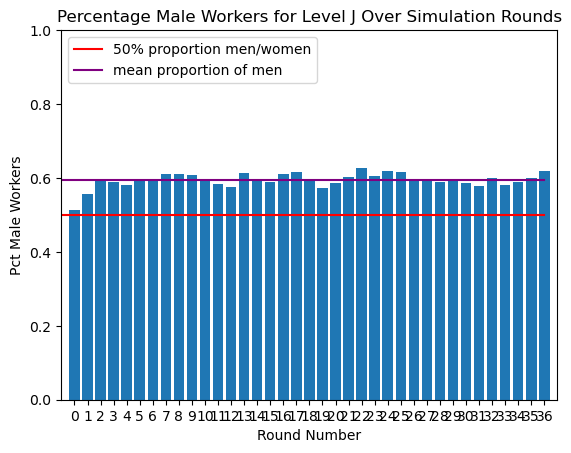

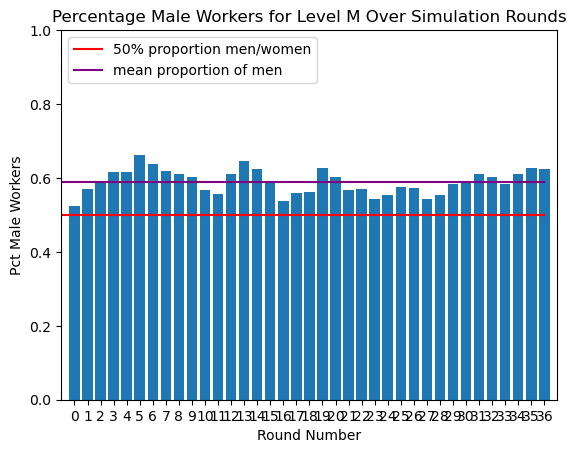

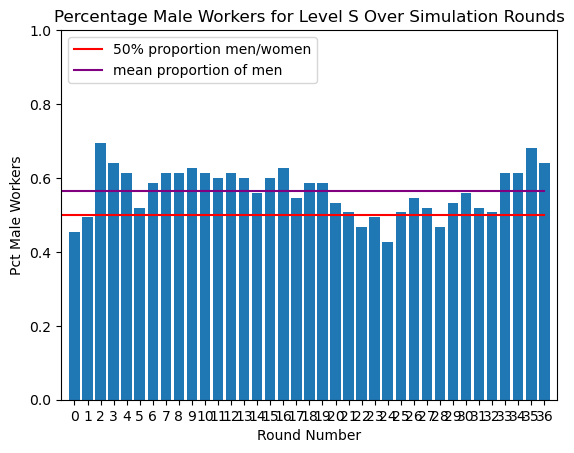

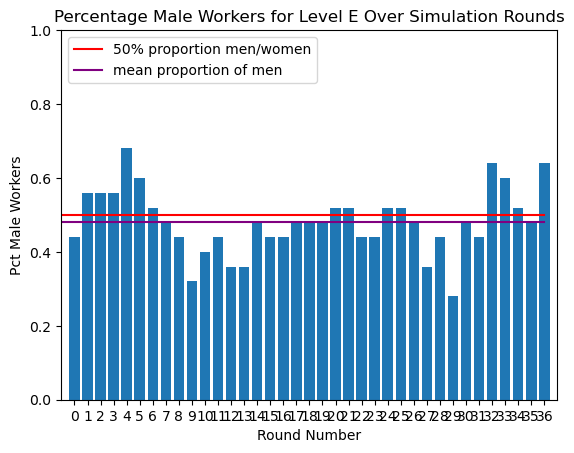

In [103]:
basic_sim = Simulation(sim_types[sim_type][0], level_sizes,\
                         sim_types[sim_type][1],sim_types[sim_type][2],\
                           sim_types[sim_type][3], False, round_length, num_rounds)

basic_sim.run_simulation(alpha, gamma, prnt=True)


In [73]:
def create_simulation_data(n, sim_type, round_length, num_rounds):
    stats = np.zeros((6,n))

    for i in range(n):
        sim = Simulation(sim_types[sim_type][0],level_sizes,\
                         sim_types[sim_type][1],sim_types[sim_type][2],\
                           sim_types[sim_type][3],False,round_length, num_rounds)
        
        alpha = max(np.random.normal(2,4),0)
        gamma = max(np.random.normal(5,4),0)
        
        stats[0, i] = 100
        stats[1, i] = 200
        
        sim.run_simulation(alpha, gamma)
        
        num_men = sim.get_final_gender_distributions()

        for j in range(len(num_men)):
            stats[j+2,i] = num_men[j]
            
        print("Simulation %i finished. %i Percent complete." % (i+1, round(100*(i+1)/n)))
    
    
    
    ts = make_timestamp()
    
    folder_path = os.path.join(path, "%s_%s_data" % (ts, sim_type))
    
    try:   
        folder = os.mkdir(folder_path)
    except:
        raise Exception("Timestamp didn't work for some reason. Please retry")
    
    listing = ts + "_" + sim_type + "_rawdata.csv"
    print(listing)
    
    save_path = os.path.join(folder_path, listing)
                                   
    np.savetxt(save_path, stats, delimiter=",")
    
    means = np.zeros(4)
    hws = np.zeros(4)
    
    rel_stats = stats[2:]
    
    for i in range(4):
        means[i], hws[i] = (rel_stats[i].mean(), rel_stats[i].std())

    for i in range(1,5):
        hws[i-1] = 1.96*hws[i-1]/math.sqrt(n)
        print("95 Perc. CI for number of men for level %s: %f +- %f" % (work_levels[i], means[i-1], hws[i-1]))

    plt.figure()
    plt.bar([work_levels[i+1] for i in range(4)], means, yerr=hws)
    plt.show()
    

Simulation 1 finished. 10 Percent complete.
Simulation 2 finished. 20 Percent complete.
Simulation 3 finished. 30 Percent complete.
Simulation 4 finished. 40 Percent complete.
Simulation 5 finished. 50 Percent complete.
Simulation 6 finished. 60 Percent complete.
Simulation 7 finished. 70 Percent complete.
Simulation 8 finished. 80 Percent complete.
Simulation 9 finished. 90 Percent complete.
Simulation 10 finished. 100 Percent complete.
321_base_rawdata.csv
95 Perc. CI for number of men for level J: 0.576000 +- 0.008307
95 Perc. CI for number of men for level M: 0.538750 +- 0.029082
95 Perc. CI for number of men for level S: 0.480000 +- 0.062290
95 Perc. CI for number of men for level E: 0.580000 +- 0.102970


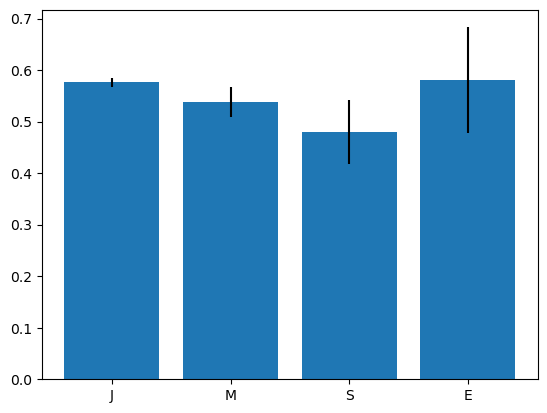

In [74]:
create_simulation_data(n, "base", round_length, num_rounds)